# Variational Quantum Eigensover (VQE)

In [39]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import EfficientSU2, TwoLocal, ZZFeatureMap
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.result import QuasiDistribution
from qiskit.transpiler.passes import Decompose
from qiskit.quantum_info import Operator

from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_algorithms import VQE, NumPyMinimumEigensolver, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA, GradientDescent, Optimizer, Minimizer
from qiskit_algorithms.gradients import  ParamShiftEstimatorGradient #, FiniteDiffEstimatorGradient, LinCombEstimatorGradient, QFI, DerivativeType, LinCombQGT

from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider

from qiskit.primitives import BackendSampler, StatevectorEstimator, StatevectorSampler
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Sampler

from scipy.optimize import minimize
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings

In [40]:
# Filters warnings into critical and non-crital
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#Necessary for tracking convergence
estimator = Estimator()
sampler = StatevectorSampler()
optimizer = COBYLA()
converter = QuadraticProgramToQubo()

# Gradient decsent methods
grad_pshift = ParamShiftEstimatorGradient(estimator) 

/var/folders/zn/x984zrb936v0hvk48xj6y_k40000gn/T/ipykernel_74769/2399550266.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [ ]:
# set number of assets which is equal to number of qubits
num_assets = 10
seed = 479  # To keep consistently generated data

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider( # Change to YahooDataProvider for real stock data
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 1, 30),
    seed=seed,
)

data.run()
ev = data.get_period_return_mean_vector() # Initial state to optimize over
covariance = data.get_period_return_covariance_matrix() # Hamiltonian Matrix

risk_factor = 0.5  # set risk factor
budget = 5  # set budget (number of assets to keep)

qp = PortfolioOptimization(expected_returns=ev, covariances=covariance, risk_factor=risk_factor, budget=budget).to_quadratic_program()
qubo = converter.convert(qp) #constraintless format to pass as operator

In [ ]:
# 3 common quantum circuits to use for ansatz with linear entanglement
ZZ_linear = ZZFeatureMap(feature_dimension=num_assets, entanglement='linear', reps=1)
SU2_linear = EfficientSU2(num_assets, entanglement='linear', reps=1)
TwoL_linear = TwoLocal(num_assets, 'ry', 'cx', entanglement='linear', reps=1)

# 3 common quantum circuits to use for ansatz with cyclic entanglement
ZZ_cyclic = ZZFeatureMap(feature_dimension=num_assets, entanglement='circular', reps=1) 
SU2_cyclic = EfficientSU2(num_assets, entanglement='circular', reps=1)
TwoL_cyclic = TwoLocal(num_assets, 'ry', 'cx', entanglement='circular', reps=1)


# 3 common quantum circuits to use for ansatz with full entanglement
ZZ_full = ZZFeatureMap(feature_dimension=num_assets, entanglement='full', reps=1)
SU2_full = EfficientSU2(num_assets, entanglement='full', reps=1)
TwoL_full = TwoLocal(num_assets, 'ry', 'cx', entanglement='full', reps=1)


# master list for ansatz circuits 
ansatz_list = [[ZZ_linear, ZZ_cyclic, ZZ_full],
                [SU2_linear, SU2_cyclic, SU2_full],
                [TwoL_linear, TwoL_cyclic, TwoL_full]]


# This starts the optimization considering all assets with equal weight
ZZ_params = [0.1] * num_assets    # ZZFeatureMap circuit has the same as the number of assets parameters,
SU2_params = [0.1] * num_assets * 4  # EfficentSU2 circuit has the same as the number of assets times 4 parameters
TwoL_params = [0.1] * num_assets * 2  # TwoLocal circuit has the double the number of assets parameters

In [ ]:
step = 0.1 # Naive step amount
H, vec = qubo.to_ising() # Extract Unitary Transformed Hamiltonian 

In [ ]:
# Standard Gradient descent method
def gd(init_params, iterations, H, step, qc_list):
    params = [[init_params], [init_params], [init_params]]
    for i in range(iterations):
        grad_lin = grad_pshift.run([qc_list[0]], [H], [params[0][i]]).result().gradients[0] 
        params[0].append(params[0][i] - step * grad_lin)
        
        grad_cyc = grad_pshift.run([qc_list[1]], [H], [params[1][i]]).result().gradients[0] 
        params[1].append(params[1][i] - step * grad_cyc)
        
        grad_full = grad_pshift.run([qc_list[2]], [H], [params[2][i]]).result().gradients[0] 
        params[2].append(params[2][i] - step * grad_full)
        #step = step * .75 # Modification to decay the step distance
    return params

# Estimate the energy level and progression toward a ground state
def estimate_energies(p, params, H, qc):
    if qc == "ZZ":
        qc1 = ZZFeatureMap(feature_dimension=num_assets, entanglement='linear', reps=p)
        qc2 = ZZFeatureMap(feature_dimension=num_assets, entanglement='circular', reps=p)
        qc3 = ZZFeatureMap(feature_dimension=num_assets, entanglement='full', reps=p)
    elif qc == "SU2":
        qc1 = EfficientSU2(num_assets, entanglement='linear', reps=p)
        qc2 = EfficientSU2(num_assets, entanglement='circular', reps=p)
        qc3 = EfficientSU2(num_assets, entanglement='full', reps=p)
    else:
        qc1 = TwoLocal(num_assets, 'ry', 'cx', entanglement='linear', reps=p)
        qc2 = TwoLocal(num_assets, 'ry', 'cx', entanglement='circular', reps=p)
        qc3 = TwoLocal(num_assets, 'ry', 'cx', entanglement='full', reps=p)     
    
    qc = [qc1, qc2, qc3]
    i=0
    ans = [[], [], []]
    for param in params:
        ans[i] = [estimator.run([qc[i]], [H], pair).result().values[0] for pair in param]
        i += 1 
    return ans

# Plots the energy level at each iteration of gradient descent to show convergence 
def plot_energies(p, params, H, qc):
    if qc == "ZZ": 
        e = estimate_energies(p, params, H, "ZZ")
    elif qc == "SU2":
        e = estimate_energies(p, params, H, "SU2")
    else:
        e = estimate_energies(p, params, H, "TwoL")
    n = len(e[0])
    labels = ['linear', 'cyclic', 'full']
    for i, s in enumerate(e):
        plt.scatter(np.arange(n), s, label=labels[i])
    plt.title(f'Convergence Analysis for $H$ with {qc}, Naive $\mu={step}$')
    plt.legend(loc=1)
    plt.ylabel('Estimated Energy')
    plt.xlabel('Iteration')
    plt.show()

In [ ]:
### Only uncomment when ready to analyze convergence ###
ZZ_result = gd(ZZ_params, 25, H, step, ansatz_list[0])
plot_energies(1, ZZ_result, H, "ZZ")

In [ ]:
SU2_result = gd(SU2_params, 25, H, step, ansatz_list[1])
plot_energies(1, SU2_result, H, "SU2")

In [ ]:
TwoL_result = gd(TwoL_params, 25, H, step, ansatz_list[2])
plot_energies(1, TwoL_result, H, "TwoL")

In [ ]:
print(SU2_result[0][25])

In [ ]:
# Plug in any ansatz to use VQE or the fastest performing one based convergence rate
num_assets = 25
budget = 20
SU2_linear = EfficientSU2(num_assets, entanglement='linear', reps=1)
best_ansatz = SU2_linear #placeholder till we know which one is the best circuit for this task

seed = 479  # To keep consistently generated data

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider( # Change to YahooDataProvider for real stock data
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 1, 30),
    seed=seed,
)

data.run()
ev = data.get_period_return_mean_vector() # Initial state to optimize over
covariance = data.get_period_return_covariance_matrix() # Hamiltonian Matrix

qp = PortfolioOptimization(expected_returns=ev, covariances=covariance, risk_factor=risk_factor, budget=budget).to_quadratic_program()
svqe = MinimumEigenOptimizer(SamplingVQE(sampler=Sampler(), ansatz=best_ansatz, optimizer=optimizer))
result = svqe.solve(qp)

In [ ]:
# Print the optimal portfolio based on budget and risk 
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )

    # Prints all the options for portfolio and their vale
    print("\n----------------- Full result ---------------------")
    print("This is a list of all possible porfolio options and their valuation:")
    print("\n\t\t selection\t\t\t\t value\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qp.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))


print_result(result)

# Classical Optimization

### Imports

In [7]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, EfficientSU2
from qiskit.result import QuasiDistribution
from qiskit.primitives import StatevectorSampler, StatevectorEstimator

from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient, SPSAEstimatorGradient, LinCombEstimatorGradient, ParamShiftEstimatorGradient, ParamShiftSamplerGradient, QFI, DerivativeType, LinCombQGT
from qiskit_optimization.translators import from_docplex_mp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import scienceplots

## Create a portfolio instance using PortfolioOptimization

In [9]:
# set number of assets which is equal to number of qubits
num_assets = 25
seed = 479

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 1, 30),
    seed=seed,
)

data.run()
ev = data.get_period_return_mean_vector() # Initial state to optimize over
covariance = data.get_period_return_covariance_matrix() # Hamiltonian Matrix

risk_factor = 0.5  # set risk factor
budget = 20  # set budget

qp = PortfolioOptimization(expected_returns=ev, covariances=covariance, risk_factor=risk_factor, budget=budget).to_quadratic_program()

## Classical Monte Carlo Simulation

In [11]:
# Portfolio optimization
best_portfolio = None
best_return = -np.inf

# Lists to store results for plotting
returns_list = []
risks_list = []

# Iterate over random portfolio allocations
for _ in range(10000):  # Try 10,000 random allocations
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    scaled_weights = weights * budget # Scale weights to fit the budget

    # Calculate portfolio return and risk
    portfolio_return = np.dot(scaled_weights, ev)  # Expected return
    portfolio_risk = np.dot(scaled_weights.T, np.dot(covariance, scaled_weights))  # Variance or RISK!!
    portfolio_std_dev = np.sqrt(portfolio_risk)  # Standard deviation

    # Calculate the adjusted return based on risk (weighted by risk_factor)
    adjusted_return = portfolio_return - risk_factor * portfolio_risk

    ## Store the results for plotting
    returns_list.append(portfolio_return)
    risks_list.append(portfolio_risk)

    ## Best Portfolio Tracking
    # Select the best portfolio based on the highest expected return
    if adjusted_return > best_return:
        best_return = adjusted_return
        best_portfolio = scaled_weights
    ########################################

# Calculate expected return of the best portfolio
expected_return_best_portfolio = np.dot(best_portfolio, ev)

# Print results
print("Best Portfolio Allocation (scaled to budget):", best_portfolio)
print(f"\nExpected Return of Best Portfolio: {expected_return_best_portfolio:.4%}")
print("Risk of Best Portfolio:", np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)))

Best Portfolio Allocation (scaled to budget): [0.91027617 1.23654739 1.29102926 0.9656355  1.52194468 0.0210373
 0.52882306 0.54084628 1.64030988 0.42325891 1.08958124 1.13067461
 1.21563913 1.37185668 1.53791187 1.45318649 0.71639206 0.41732544
 0.16025959 0.0127562  0.53495969 0.14079375 0.6151333  0.48765095
 0.03617055]

Expected Return of Best Portfolio: 12.4791%
Risk of Best Portfolio: 0.17700860220543


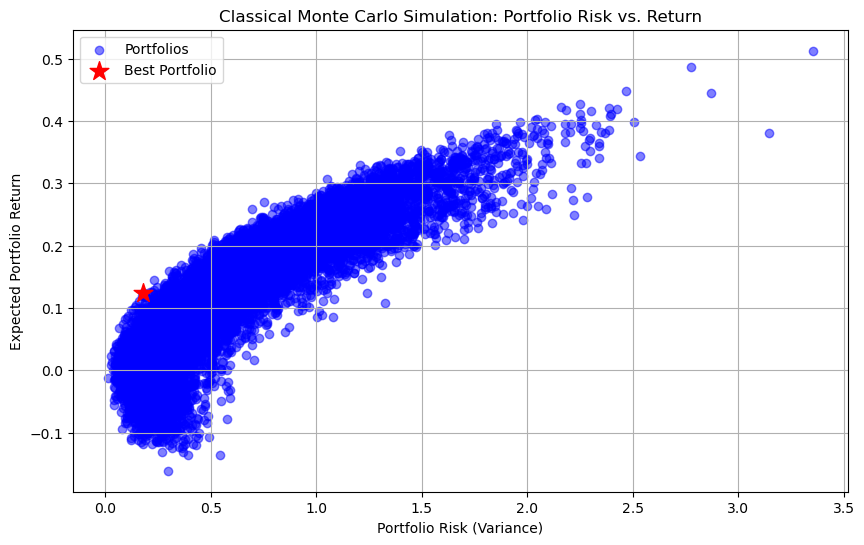

In [12]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Portfolios')
plt.scatter(np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)), np.dot(ev, best_portfolio),
            color='red', marker='*', s=200, label='Best Portfolio')
plt.title('Classical Monte Carlo Simulation: Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid()
plt.show()

### Global Minimum-Variance Portfolio (GMVP)

In [14]:
from scipy.optimize import minimize



GMVP Weights (scaled to budget): [1.02652615 0.95667758 1.01374508 1.00403987 0.94206605 0.99762256
 0.01274272 1.01433397 1.07882557 0.092016   1.00421664 0.98645897
 1.03660473 0.96722464 1.00195748 1.00704283 1.03551401 0.96782747
 0.02901428 0.         0.         1.00484405 0.94075794 0.87072142
 1.00922   ]

Expected Return of GMVP: -0.0641%
Risk of GMVP: 0.00889618731780511


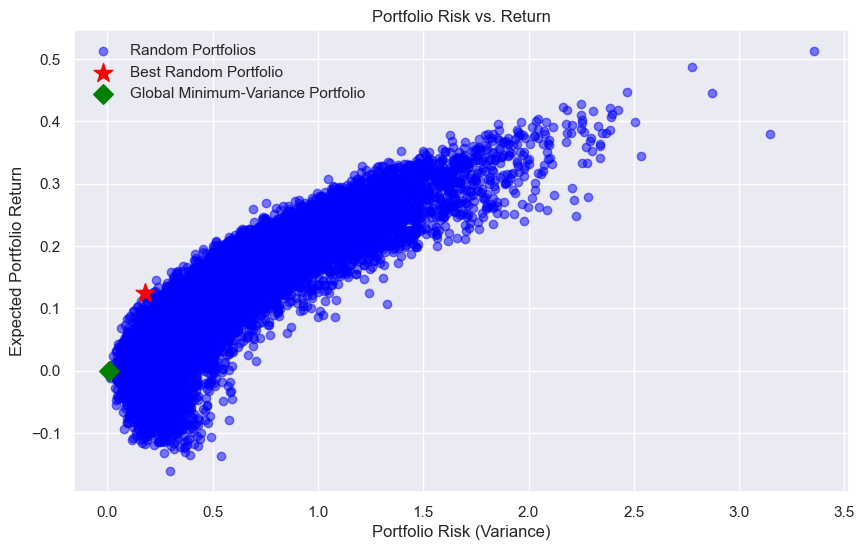

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


# -------------------------------
# Compute the Global Minimum-Variance Portfolio (GMVP)
# -------------------------------

# Define the portfolio variance function to minimize
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: Sum of weights equals 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Bounds: Weights between 0 and 1 (long-only constraint)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess: Equal weights
initial_guess = num_assets * [1.0 / num_assets]

# Optimize to find the GMVP weights
result = minimize(
    portfolio_variance,
    initial_guess,
    args=(covariance,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract the GMVP weights
gmvp_weights = result.x

# Calculate GMVP return and risk
gmvp_return = np.dot(gmvp_weights, ev) * budget  # Scale by budget
gmvp_variance = portfolio_variance(gmvp_weights * budget, covariance)  # Scale weights
gmvp_std_dev = np.sqrt(gmvp_variance)

print("\nGMVP Weights (scaled to budget):", gmvp_weights * budget)
print(f"\nExpected Return of GMVP: {gmvp_return:.4%}")
print("Risk of GMVP:", gmvp_variance)


# -------------------------------
# Plotting the results
# -------------------------------

# Reset all Matplotlib settings to default
mpl.rcParams.update(mpl.rcParamsDefault)

# Disable LaTeX rendering explicitly
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'  # Use DejaVu Sans instead of LaTeX

# Re-apply desired styles that don't require LaTeX
plt.style.use('seaborn-v0_8-darkgrid')  # Alternative style without LaTeX dependency
sns.set()

# Your plotting code
plt.figure(figsize=(10, 6))

# Scatter plot of random portfolios
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Random Portfolios')

# Plot the Best Portfolio from Random Sampling
plt.scatter(
    np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)),
    np.dot(ev, best_portfolio),
    color='red',
    marker='*',
    s=200,
    label='Best Random Portfolio'
)

# Plot the GMVP
plt.scatter(
    gmvp_variance,
    gmvp_return,
    color='green',
    marker='D',
    s=100,
    label='Global Minimum-Variance Portfolio'
)

plt.title('Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()

### Minimum Eigensolver

In [17]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

In [18]:
#classical optimizer
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

print(result)  # if x_n = 1.0 : buy, if x_n = 0.0 : do not buy

fval=-0.0018984848782011912, x_0=1.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0, x_10=1.0, x_11=1.0, x_12=1.0, x_13=1.0, x_14=1.0, x_15=1.0, x_16=1.0, x_17=1.0, x_18=0.0, x_19=0.0, x_20=0.0, x_21=1.0, x_22=1.0, x_23=1.0, x_24=1.0, status=SUCCESS


In [19]:
# Extract optimal weights
optimal_weights = result.x

expected_return_optimal = np.dot(optimal_weights, ev)

# Print results
print("Optimal Portfolio Allocation (scaled to budget):", optimal_weights )#* budget)
print(f"\nExpected Return of Optimal Portfolio: {expected_return_optimal:.4%}")
print("Risk of Optimal Portfolio:", np.dot(optimal_weights.T, np.dot(covariance, optimal_weights)))

Optimal Portfolio Allocation (scaled to budget): [1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1.]

Expected Return of Optimal Portfolio: 2.0669%
Risk of Optimal Portfolio: 0.03754046707115206


Optimal Portfolio Allocation (VQE): [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1.]

Expected Return of Optimal Portfolio (VQE): 1.2048%
Risk of Optimal Portfolio (VQE): 0.08113489865004302


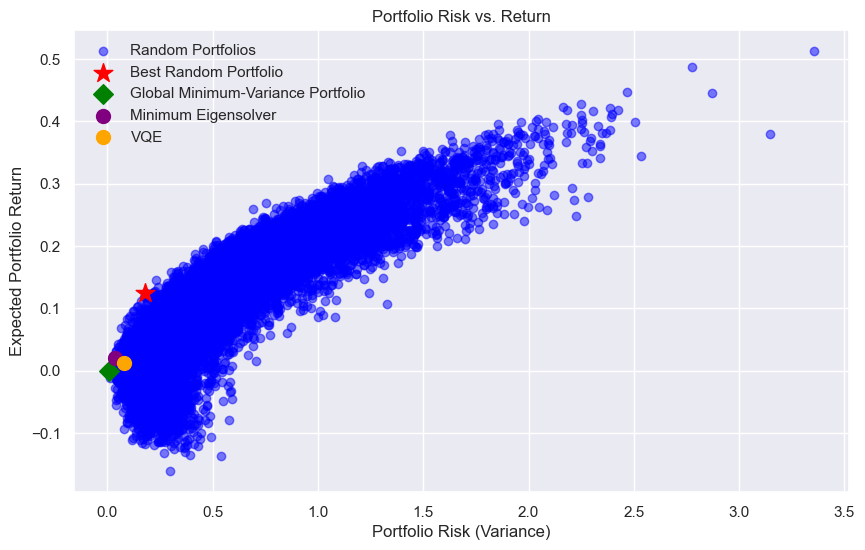

In [49]:
optimal_risk = np.dot(optimal_weights.T, np.dot(covariance, optimal_weights))  # Calculate risk of the optimal portfolio
optimal_return = np.dot(optimal_weights, ev)  # Calculate expected return of the optimal portfolio

plt.figure(figsize=(10, 6))

# Scatter plot of random portfolios
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Random Portfolios')

# Plot the Best Portfolio from Random Sampling
plt.scatter(
    np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)),
    np.dot(ev, best_portfolio),
    color='red',
    marker='*',
    s=200,
    label='Best Random Portfolio'
)

# Plot the GMVP
plt.scatter(
    gmvp_variance,
    gmvp_return,
    color='green',
    marker='D',
    s=100,
    label='Global Minimum-Variance Portfolio'
)

# Plot the Minimum Eigensolver
plt.scatter(
    optimal_risk,
    optimal_return,
    color='purple',  # Different color for distinction
    marker='o',  # Circle marker
    s=100,  # Size of the marker
    label='Minimum Eigensolver'
)

#Plot the VQE 7, 14, 18, 19, 20
vqe_weights = np.array([1.,1.,1.,1.,1., 1., 0., 1.,1.,1.,1.,1.,1.,0.,1.,1.,1.,0.,0.,0.,1.,1.,1.,1.,1.])
vqe_return = np.dot(vqe_weights, ev)
vqe_risk = np.dot(vqe_weights.T, np.dot(covariance, vqe_weights))

plt.scatter(
    vqe_risk,
    vqe_return,
    color='orange',  # Different color for distinction
    marker='o',  # Circle marker
    s=100,  # Size of the marker
    label='VQE'
)
print("Optimal Portfolio Allocation (VQE):", vqe_weights )#* budget)
print(f"\nExpected Return of Optimal Portfolio (VQE): {vqe_return:.4%}")
print("Risk of Optimal Portfolio (VQE):", vqe_risk)

plt.title('Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()